# <center> **NLP analysis of jokes dataset**

## Table of Contents

1. **[RNN models](#5)**
	* [Pretrained embedding (word2vec)](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
     + [GRU](#sub-sub-heading-2)
	* [Glove Embedding](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [RNN](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)
     + [Bidirectional LSTM](#sub-sub-heading-2)
	* [Make own vocab by train word2vec model](#sub-heading)
     + [Dataset loader](#sub-sub-heading-1) 
     + [Split](#sub-sub-heading-2)
     + [LSTM](#sub-sub-heading-2)




In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
import os
import string

import plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='PROGRESS>>>')

from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import gensim.downloader as gensim_api
from torch.nn.utils.rnn import pad_sequence

from functools import partial

import re
import gc

import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
text_columns = ['joke']

# Read data: 

In [4]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/data/jokes_dataset_MAIN_PREPROC_regression.csv', 
                 sep=',', 
                 encoding='utf-8').set_index('id')

In [5]:
data.head()

,joke,Log1pRank
id,,
5tz52q,I hate how you cannot even say black paint any...,0.693147
5tz4dd,What is the difference between a Jew in Nazi G...,0.000000
5tz319,I recently went to America..... ...and being t...,0.000000
5tz2wj,"Brian raises his hand and says, ""He is in Heav...",0.693147
5tz1pc,You hear about the University book store worke...,0.000000


In [6]:
data.dropna(inplace=True)

In [7]:
data.isna().sum()

joke         0
Log1pRank    0
dtype: int64

# **Preprocessing text data**

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [8]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur "joke" in total

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(500000, 600000)
assert len(token_counts) in range(80000, 90000)
print('Correct!')

Total unique tokens : 80705
('the', 526870)
('.', 434872)
(',', 412333)
('a', 331822)
('and', 246287)
...
('uhr', 1)
('pinat', 1)
('ddr', 1)
Correct!


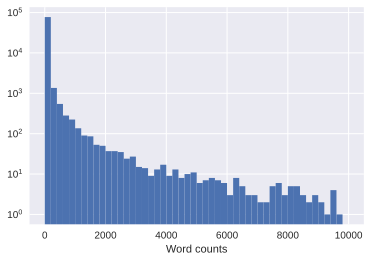

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Get a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(19000, 21000)
assert 'lol' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 20372
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in tokens (int)

In [14]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf')) # общ правило - 95 квантиль
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

Example:

In [17]:
print("Lines:")
print('\n'.join(data["joke"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["joke"][::100000]))

Lines:
i hate how you cannot even say black paint anymore . now i have to say " leroy can you please paint the fence ?"
i wish labor day was months after spring break .

Matrix:
[[ 9107  8489  8972 20272  3053  6461 15607  2227 12857  1203   304 12308
   9107  8508 18411 15607    67 10470  3021 20272 13551 12857 18169  6898
    458]
 [ 9107 20009 10222  4959 19665 11684   834 17026  2591   304     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1]]


### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  152111
Validation size =  38028


In [19]:
TARGET_COLUMN = "Log1pRank"

In [20]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["joke"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["joke"] = as_matrix(data["joke"].values, max_len)
    
    if word_dropout != 0:
        batch["joke"] = apply_word_dropout(batch["joke"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
make_batch(data_train[:3], max_len=10)

{'Log1pRank': tensor([0.0000, 1.6094, 0.6931], dtype=torch.float64),
 'joke': tensor([[13869,  9664, 10562, 13661,   304, 20272, 19508,   546, 10771,  1103],
         [  834, 15040,   254,  9107, 19788, 18411, 18169, 16714, 15839, 12474],
         [18211,  1430, 11225,  9146,  9107, 19630, 18411,  7895, 18411,     0]])}

# **Regression**

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [22]:
import torch
import torch.nn as nn
import torch.functional as F

In [23]:
class RankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
      
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1),
          
        )
       
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size , hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        self.double()
        
    def forward(self, batch):
        description_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        # features = torch.cat(
        #     [description_features], dim=1)
        out = self.final_predictor(description_features).squeeze()
        
        return out

In [24]:
model = RankPredictor()

In [25]:
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [26]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [27]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cpu') # cuda

In [28]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [29]:
model = RankPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


  0%|          | 0/1188 [00:00<?, ?it/s]

train_loss 0.41124500523885194
val results:
Mean square error: 0.21737
Mean absolute error: 0.30391
train_loss 0.347147508738484
val results:
Mean square error: 0.21174
Mean absolute error: 0.29978
train_loss 0.4316064379902248
val results:
Mean square error: 0.21222
Mean absolute error: 0.30063
train_loss 0.38535349839489264
val results:
Mean square error: 0.21204
Mean absolute error: 0.30068
train_loss 0.4662788163936866
val results:
Mean square error: 0.21192
Mean absolute error: 0.30071
train_loss 0.3760167232755909
val results:
Mean square error: 0.21429
Mean absolute error: 0.30275
train_loss 0.35003309135792987
val results:
Mean square error: 0.20663
Mean absolute error: 0.29594
train_loss 0.4163145603466426
val results:
Mean square error: 0.21089
Mean absolute error: 0.29974
train_loss 0.3803907613747949
val results:
Mean square error: 0.21085
Mean absolute error: 0.29964
train_loss 0.3667436379881001
val results:
Mean square error: 0.20851
Mean absolute error: 0.29768
train_lo

  0%|          | 0/1188 [00:00<?, ?it/s]

train_loss 0.36858141795805227
val results:
Mean square error: 0.20711
Mean absolute error: 0.29650
train_loss 0.3559752081714731
val results:
Mean square error: 0.20623
Mean absolute error: 0.29561
train_loss 0.3945144070529365
val results:
Mean square error: 0.20858
Mean absolute error: 0.29777
train_loss 0.3514083955774554
val results:
Mean square error: 0.20525
Mean absolute error: 0.29463
train_loss 0.3642519782391993
val results:
Mean square error: 0.20763
Mean absolute error: 0.29691
train_loss 0.3942899279610048
val results:
Mean square error: 0.20773
Mean absolute error: 0.29723
train_loss 0.3548105467495007
val results:
Mean square error: 0.21011
Mean absolute error: 0.29922
train_loss 0.417463195000523
val results:
Mean square error: 0.20683
Mean absolute error: 0.29619
train_loss 0.3601761328794574
val results:
Mean square error: 0.20608
Mean absolute error: 0.29560
train_loss 0.39585043459844904
val results:
Mean square error: 0.20303
Mean absolute error: 0.29277
train_los

  0%|          | 0/1188 [00:00<?, ?it/s]

train_loss 0.38140958462680596
val results:
Mean square error: 0.20627
Mean absolute error: 0.29590
train_loss 0.39981999737896995
val results:
Mean square error: 0.20442
Mean absolute error: 0.29420
train_loss 0.36359365847455477
val results:
Mean square error: 0.20578
Mean absolute error: 0.29534
train_loss 0.4070062665668494
val results:
Mean square error: 0.20675
Mean absolute error: 0.29631
train_loss 0.39284102068729426
val results:
Mean square error: 0.20117
Mean absolute error: 0.29096
train_loss 0.3669975017828552
val results:
Mean square error: 0.20313
Mean absolute error: 0.29299
train_loss 0.3479784634818772
val results:
Mean square error: 0.20548
Mean absolute error: 0.29518
train_loss 0.4046489222147054
val results:
Mean square error: 0.20734
Mean absolute error: 0.29685
train_loss 0.36222081119963473
val results:
Mean square error: 0.20418
Mean absolute error: 0.29384
train_loss 0.37250546785604177
val results:
Mean square error: 0.20364
Mean absolute error: 0.29338
trai

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [39]:
def get_preds(model, data, batch_size=BATCH_SIZE, name="", **kw):
    preds = []
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            preds.append(batch_pred)
        features = torch.cat(
            preds, dim=0)
        return features

In [40]:
features = get_preds(model, data_val, name='val', batch_size=512, device=DEVICE)

In [42]:
def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [45]:
calc_metrics(data_val['Log1pRank'], features)

*** VAL **: 
MSE:   0.4027708865459231
RMSE:  0.6346423296203327
R2:    0.0073293711953617
MAE:   0.5828114207411131
MedAE: 0.6366513591869927
------------------------------
